In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import pandas as pd


In [2]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789

# _r =  2.6392235755368e-06
# _K = 8.061743253740993e-05
# _gain = np.sqrt(335982165125421.5 )

_r =  1.673973370516074e-06
_K = 7.264521400417836e-05
_gain = np.sqrt(630330834489321.9)

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous

bin_number_data = 40
timestep_data = bin_number_data/200000000

print(timestep_data)
print("momentum relation time is " + str(_m/_v_force))
# TOLERANCES
tols = [.0051]
gap_min = 500

2e-07
momentum relation time is 7.947313247072445e-06


In [3]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return msd_, lag_times


In [4]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [5]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mcthu\PycharmProjects\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 10
fs_sim = 1/(timestep_sim * bin_num_sim)
print(1/fs_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)


# GET THE EQ MSD
all_msd_sim = []
lag_times_sim = 0
for series in traces_sim:
    msd, lag_times_sim = compute_msd(series[:100000], timestep_sim*bin_num_sim)
    all_msd_sim.append(msd)

eq_msd_sim = np.mean(all_msd_sim, axis=0)



1.9754935012178623e-08


100%|██████████| 100000/100000 [00:08<00:00, 11832.73it/s]


In [6]:
# SIM PART 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
sim_tol_msds = []
init_lag_times_sim = 0

for tol in tols:
    all_init_msd_sim = []
    init_len = int(len(traces_sim[0])/1000)
    
    # msd_num_lim = 5000
    # j = 0
    
    for i in range(len(traces_sim)):
        zero_idxs_sim = []
        print("std of sim data vel " + str(np.std(v_traces_sim[i])))
        print("kbt/m" + str(np.sqrt(_k_b*_temp/_m)))
        v_tolerance = tol * np.sqrt(_k_b*_temp/_m)
        v_indices = np.where(abs(v_traces_sim[i]) < v_tolerance)[0]
        print("v idx sim: " + str(len(v_indices)))

        # last_idx = -np.inf
        #
        # p_tolerance = (tol * np.std(traces_sim[i]))
        # p_indices = np.where(abs(traces_sim[i]) < p_tolerance)[0]
        # print("p idx data: " + str(len(p_indices)))
        # overlap = np.intersect1d(v_indices, p_indices)
        # print("overlap data: " + str(len(overlap)))

        # for idx in overlap:
        #     if idx - last_idx > (init_len / gap_min) and idx + init_len < len(traces_sim[i]):
        #         zero_idxs_sim.append(idx)
        #         last_idx = idx
        # NO POSITION

        for idx in v_indices:
            if idx + init_len < len(traces_sim[i]): #idx - last_idx > (init_len / 100) and
                zero_idxs_sim.append(idx)
                last_idx = idx

        print("total idx sim: " + str(len(zero_idxs_sim)))
    
        for idx in zero_idxs_sim:
            # j+=1
            # if j > msd_num_lim:
            #     break
            msd, init_lag_times_sim = compute_init_msd2(traces_sim[i][idx:idx+init_len], timestep_sim*bin_num_sim)
            all_init_msd_sim.append(msd)
    
    init_msd_sim = np.mean(all_init_msd_sim, axis=0)
    sim_tol_msds.append(init_msd_sim)

std of sim data vel 0.00010643373808415319
kbt/m0.0002116845693462522
v idx sim: 12875
total idx sim: 12871


In [7]:
# DATA

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks1 = []

for chunk in pd.read_csv(rf'C:\Users\mcthu\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_position_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks1.append(chunk)

data_df_pos_data = pd.concat(chunks1, ignore_index=True)

chunks2 = []

for chunk in pd.read_csv(rf'C:\Users\mcthu\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_velocity_bin{bin_number_data}.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks2.append(chunk)

data_df_vel_data = pd.concat(chunks2, ignore_index=True)

# Convert DataFrame into a numpy array where each column is an entry
traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry

# Convert DataFrame into a numpy array where each column is an entry
v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry


# GET THE EQ MSD
all_msd_data = []
lag_times_data = 0
for series in traces_data:
    msd, lag_times_data = compute_msd(series, timestep_data)
    all_msd_data.append(msd)

eq_msd_data = np.mean(all_msd_data, axis=0)


  0%|          | 1828/419430 [00:07<30:08, 230.96it/s]


KeyboardInterrupt: 

In [8]:
# DATA PT 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
data_tol_msds = []
init_lag_times_data = 0
for tol in tols:
        
    all_init_msd_data = []
    init_len = int(len(traces_data[0])/10)
    #
    msd_num_lim = 5000
    j = 0
    
    for i in range(len(traces_data)):
        zero_idxs_data = []
        print("STD of vel data "+ str(np.std(v_traces_data[i])))
        print("sqrt kbt/m "+ str(np.sqrt(_k_b*_temp/_m)))
        v_tolerance = tol * np.sqrt(_k_b*_temp/_m)
        v_indices = np.where(np.abs(v_traces_data[i]) < v_tolerance)[0]
        last_idx = -np.inf

        # p_tolerance = (tol * np.std(traces_data[i]))
        # p_indices = np.where(abs(traces_data[i]) < p_tolerance)[0]
        # print("p idx data: " + str(len(p_indices)))

        # overlap = np.intersect1d(v_indices, p_indices)
        # print("overlap idx data: " + str(len(overlap)))
        # for idx in overlap:
        #     if idx + init_len < len(traces_data[i]):#idx - last_idx > (init_len / gap_min) and
        #         zero_idxs_data.append(idx)

        # NO POSITION
        for idx in v_indices:
            if idx + init_len < len(traces_data[i]) and idx>100:
                zero_idxs_data.append(idx)

        # def find_adjacent_groups(arr):
        #     arr = np.sort(np.unique(arr))  # Sort and deduplicate
        #     splits = np.where(np.diff(arr) != 1)[0] + 1
        #     groups = np.split(arr, splits)
        #     return groups
        #
        # groups = find_adjacent_groups(zero_idxs_data)

        # zero_idxs_data_f = []
        # for group in groups:
        #     # print(group)
        #     # print(group[-1])
        #     zero_idxs_data_f.append(group[-1])
        # zero_idxs_data_ff = []
        # last_idx = -np.inf

        # for idx in zero_idxs_data_f:
        #     if idx - last_idx > (init_len / gap_min):
        #         last_idx = idx
        #         zero_idxs_data_ff.append(idx)
    
        print("total idx data: " + str(len(zero_idxs_data)))

        for idx in zero_idxs_data:
            # print(idx)
            # j+=1
            # if j > msd_num_lim:
            #     break
            msd = compute_init_msd(traces_data[i][idx:idx+init_len])
            init_lag_times_data = timestep_data*np.arange(len(msd))
            all_init_msd_data.append(msd)
    
    init_msd_data = np.mean(all_init_msd_data, axis=0)
    data_tol_msds.append(init_msd_data)

STD of vel data 5198.051334096374
sqrt kbt/m 0.0002116845693462522
total idx data: 0
STD of vel data 5171.002588646007
sqrt kbt/m 0.0002116845693462522
total idx data: 0
STD of vel data 5189.472524370787
sqrt kbt/m 0.0002116845693462522
total idx data: 0
STD of vel data 5223.7273771698765
sqrt kbt/m 0.0002116845693462522
total idx data: 0
STD of vel data 5168.67302550508
sqrt kbt/m 0.0002116845693462522
total idx data: 0


C:\Users\mcthu\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mcthu\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Error bar calculation
import numpy as np
from scipy.optimize import brentq
import numpy as np
from scipy.optimize import brentq

def estimate_corrected_error2(data):
    x = np.array(data, dtype=np.float64)

    # Normalize to avoid floating point underflow
    scale = np.max(np.abs(x))
    if scale == 0:
        return {
            "mean": 0.0,
            "std_dev": 0.0,
            "correlation_factor_f": 0.0,
            "corrected_error_bar": 0.0
        }
    x_scaled = x / scale

    N = len(x_scaled)
    mean = np.mean(x_scaled)
    s2 = np.var(x_scaled, ddof=1)
    if s2 == 0:
        return {
            "mean": mean * scale,
            "std_dev": 0.0,
            "correlation_factor_f": 0.0,
            "corrected_error_bar": 0.0
        }

    s = np.sqrt(s2)
    x_centered = x_scaled - mean
    numerator = np.sum(x_centered ** 2)
    sum_xc = np.sum(x_centered)

    def chi_squared(f):
        if not (0 < f < 1):
            return np.inf

        try:
            denominator = 1 - f
            correction = f / (1 + f * (N - 1))
            total = (numerator / s2 - correction * (sum_xc ** 2) / s2) / denominator
            if not np.isfinite(total):
                return np.inf
            return total - (N - 1)
        except Exception:
            return np.inf

    # Try to solve for f, with fallback if it fails
    try:
        f_opt = brentq(chi_squared, 1e-4, 0.999)
    except ValueError:
        f_opt = 0.0  # fallback: assume no correlation

    sigma_corrected = s * np.sqrt((1 + f_opt * (N - 1)) / N)

    # Rescale outputs
    return {
        "mean": mean * scale,
        "std_dev": s * scale,
        "correlation_factor_f": f_opt,
        "corrected_error_bar": sigma_corrected * scale
    }

def estimate_corrected_error(data):

    x = np.array(data)
    N = len(x)
    mean = np.mean(x)
    s2 = np.var(x, ddof=1)
    s = np.sqrt(s2)
    x_centered = x - mean

    # Function to solve: Schmelling's chi^2(f) = N - 1
    def chi_squared(f):
        numerator = np.sum(x_centered ** 2)
        denominator = 1 - f
        correction = f / (1 + f * (N - 1))
        total = (numerator / s2 - correction * (np.sum(x_centered) ** 2) / s2) / denominator
        return total - (N - 1)

    # Solve for f in a safe range [0, 0.999] to avoid singular matrix
    f_opt = brentq(chi_squared, 1e-2, 0.999)

    # Corrected standard error of the mean
    sigma_corrected = s * np.sqrt((1 + f_opt * (N - 1)) / N)

    return {
        "mean": mean,
        "std_dev": s,
        "correlation_factor_f": f_opt,
        "corrected_error_bar": sigma_corrected
    }


In [10]:
import math
from scipy import constants

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)
#
def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))



In [11]:
# LOOK FOR SPECIFIC SPEEDS
# SIM PART 3

# speeds = [0, .5, .75, 1, 2, 4]
speeds = [0, .5, 1, 2, 3]
# traces_per_speed = [0, 0, 0, 0, 0, 0]
traces_per_speed = [0, 0, 0, 0, 0]
# GET THE VAR INT MSD

sim_speeds_msds = []
data_speeds_msds = []
error_bar_speeds= []

# speed_tol = [.015, .015, .015, .015, .015, .015]
speed_tol = [.0015, .0015, .0015, .015, .04]
lag_times_speed_sim = 0
lag_times_speed_data = 0

for s in range(len(speeds)):
    #Comment out SIM
    # all_speed_msd_sim = []
    all_speeds_msd_data = []
    # init_len_sim = int(len(traces_sim[0])/70)
    init_len_data = int(len(traces_data[0])/30)

    # for i in range(len(traces_sim)):
        # speed_idxs_sim = []
        # print("std of sim vel " + str(np.std(v_traces_sim[i])))
        # v_tolerance = (speeds[s] * np.std(v_traces_sim[i]))
        # speed_tolerance = speed_tol[s] * np.std(v_traces_sim[i])
        # v_indices_sim = np.where((v_traces_sim[i] < v_tolerance + speed_tolerance) & (v_traces_sim[i] > v_tolerance - speed_tolerance))[0]
        # print("speed idx sim: " + str(len(v_indices_sim)))
        #
        # for idx in v_indices_sim:
        #     if idx + init_len_sim < len(traces_sim[i]):
        #         speed_idxs_sim.append(idx)
        #
        # print("total idx speed sim: " + str(len(speed_idxs_sim)))
        #
        # for idx in speed_idxs_sim:
        #     msd, lag_times_speed_sim = compute_init_msd2(traces_sim[i][idx:idx+init_len_sim], timestep_sim*bin_num_sim)
        #     all_speed_msd_sim.append(msd)

    for i in range(len(traces_data)):
        speed_idxs_data = []
        print("std of data vel " + str(np.std(v_traces_data[i])))
        # print("sqrt kbt/m" + str(np.sqrt(_k_b*_temp/_m)))
        # print("times gain " + str(_gain * np.sqrt(_k_b*_temp/_m)))
        v_tolerance = (speeds[s] * _gain * np.sqrt(_k_b*_temp/_m))
        speed_tolerance = speed_tol[s] * _gain * np.sqrt(_k_b*_temp/_m)
        v_indices_data = np.where((v_traces_data[i] < v_tolerance + speed_tolerance) & (v_traces_data[i] > v_tolerance - speed_tolerance))[0]
        # print("speed idx data: " + str(len(v_indices_data)))

        for idx in v_indices_data:
            if idx + init_len_data < len(traces_data[i]):
                speed_idxs_data.append(idx)

        print("total idx data: " + str(len(speed_idxs_data)))
        traces_per_speed[s] += len(speed_idxs_data)
        for idx in speed_idxs_data:
            msd, lag_times_speed_data = compute_init_msd2(traces_data[i][idx:idx+init_len_data], timestep_data)
            all_speeds_msd_data.append(msd)

    print(f"-------TOTAL TRACES DATA {traces_per_speed[s]}------------")
    # speed_msd_sim = np.mean(all_speed_msd_sim, axis=0)

    # Calculate error bar for each lag time at this speed
    # print(f"SHAPE {np.array(all_speeds_msd_data).shape}")
    all_speeds_msd_data_array = np.array(all_speeds_msd_data)

    all_lag_data_groups = all_speeds_msd_data_array.T

    error_bars_for_speed = []
    for lag in all_lag_data_groups:
        dict = estimate_corrected_error2(lag)
        error_bars_for_speed.append(dict["corrected_error_bar"])
    speed_msd_data = np.mean(all_speeds_msd_data_array, axis=0)

    # sim_speeds_msds.append(speed_msd_sim)
    data_speeds_msds.append(speed_msd_data)
    error_bar_speeds.append(error_bars_for_speed)


std of data vel 5198.051334096374
total idx data: 525
std of data vel 5171.002588646007
total idx data: 467
std of data vel 5189.472524370787
total idx data: 493
std of data vel 5223.7273771698765
total idx data: 502
std of data vel 5168.67302550508
total idx data: 494
-------TOTAL TRACES DATA 2481------------
std of data vel 5198.051334096374
total idx data: 411
std of data vel 5171.002588646007
total idx data: 459
std of data vel 5189.472524370787
total idx data: 441
std of data vel 5223.7273771698765
total idx data: 450
std of data vel 5168.67302550508
total idx data: 447
-------TOTAL TRACES DATA 2208------------
std of data vel 5198.051334096374
total idx data: 304
std of data vel 5171.002588646007
total idx data: 294
std of data vel 5189.472524370787
total idx data: 314
std of data vel 5223.7273771698765
total idx data: 293
std of data vel 5168.67302550508
total idx data: 325
-------TOTAL TRACES DATA 1530------------
std of data vel 5198.051334096374
total idx data: 567
std of dat

In [12]:
times_analytic = np.logspace(-6.5, -2.5, 1000)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 2000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))
#
# for i in range(num_samples):
#     results[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], 0, roots, _temp)

speeds_analytic = []
speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in range(num_samples):
        results_speed[i, :] = stat_hydro_msd(times_analytic, roots)
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic.append(results_speed.mean(axis=0))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed = np.zeros((num_samples, len(times_analytic)))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))

averaged_initial_msd = results.mean(axis=0)


Speed X


C:\Users\mcthu\AppData\Local\Temp\ipykernel_22632\2692747432.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  results_speed[i, :] = stat_hydro_msd(times_analytic, roots)


Speed X
Speed X
Speed X
Speed X


tp is 7.947313247072445e-06
6.141459502389972e-06


<Figure size 1000x1000 with 0 Axes>

C:\Users\mcthu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


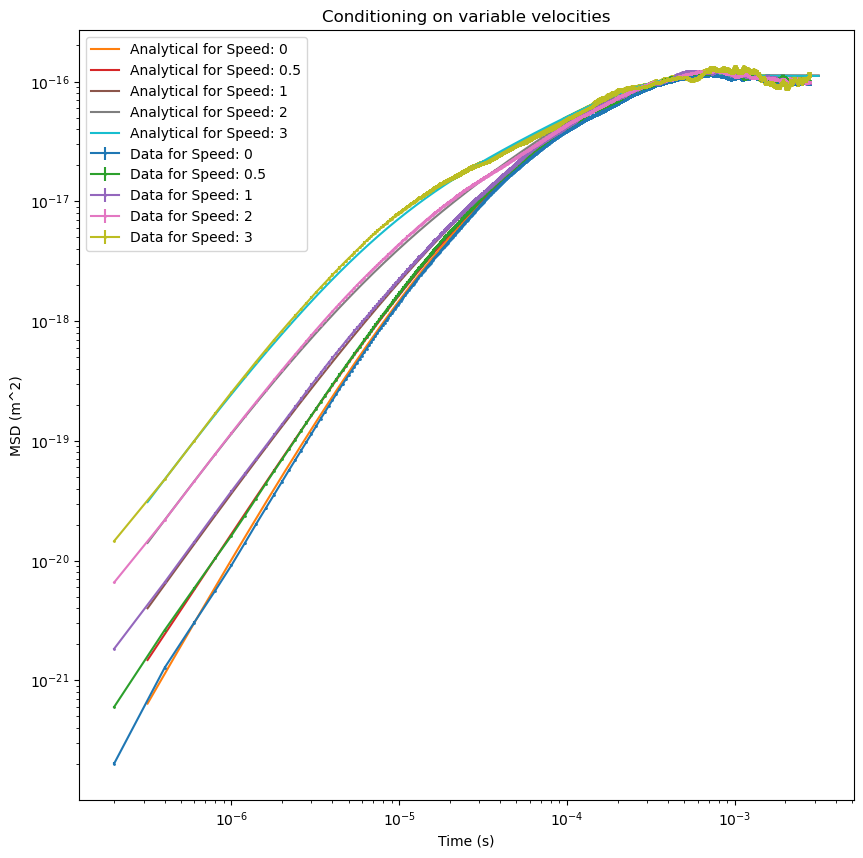

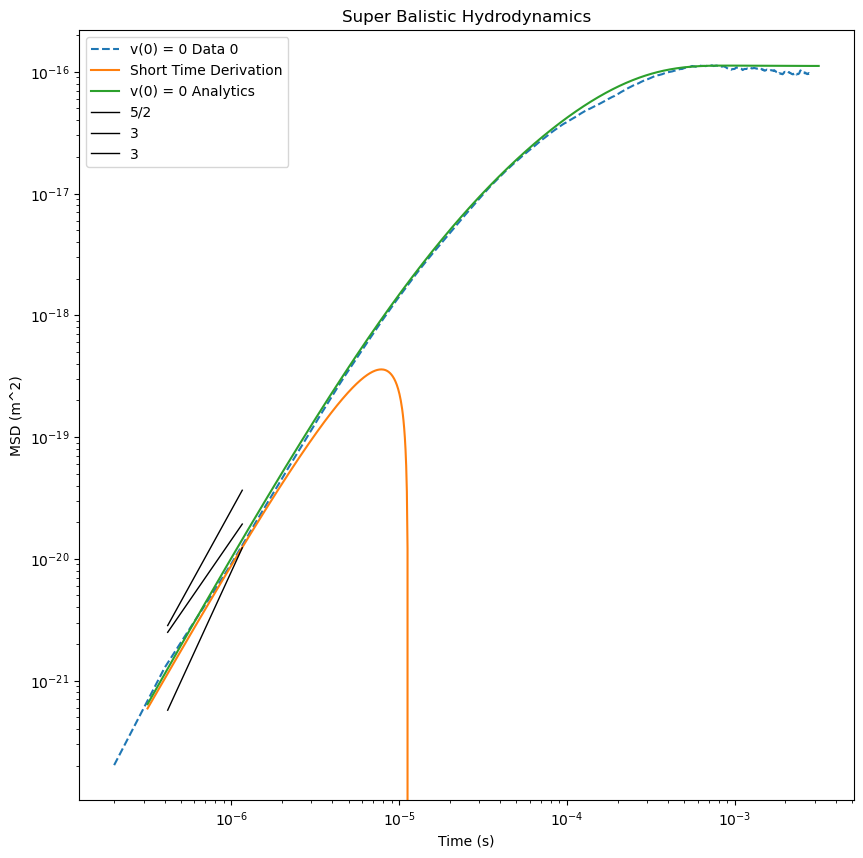

In [15]:
# GRAPHING
plt.figure(figsize=(10,10))

#  Set times for analytic functions

init_zero_WN_analytic = just_noise(times_analytic)
analytic_tol_msds = []
for tol in tols:
    init_var_WN_analytic = known_initial_v_0(times_analytic, tol)
    analytic_tol_msds.append(init_var_WN_analytic)
WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

# laplace_form = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), 0, roots, _temp)
# laplace_form2 = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), (.5 * np.average(np.abs((v_traces_data[0]))))/_gain, roots, _temp)
# stationairy1 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), np.sqrt(_k_b*_temp/_m), roots, _temp)
# stationairy2 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, 0,0, roots, _temp)

def form_func(times):
    return (2/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force)) - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_5_2(times):
    return (4/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_2(times):
    return (2/100)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_3(times):
    return (1000)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(3)*(_k_b*_temp/(_m**2/_v_force))# - 2/3

def graph_2(times):
    return (np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))/550

plt.figure(figsize=(10,10))

# ANALYTIC GRAPHING
# plt.plot(times_analytic, stationairy2*_gain**2, label="stationairy 2")
# plt.plot(times_analytic, stationairy1*_gain**2, label="stationairy 1")
# plt.plot(times_analytic, laplace_form*_gain**2, linewidth=4, label="inital zero basset", color='green')
# plt.plot(times_analytic, averaged_initial_msd*_gain**2, label="cole FORM2")
# plt.scatter(times_analytic, laplace_form2*_gain**2, s=.2, label="cole FORM2")
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="5/2", color='black', linewidth=3)
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="2", color='black', linewidth=3)
# plt.plot(times_analytic, init_zero_WN_analytic*_gain**2, linestyle='dashed', label="Initial Zero White")
# plt.plot(times_analytic, analytic_tol_msds[0], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[0]}")
# for i in range(len(tols)):
#     plt.plot(times_analytic, analytic_tol_msds[i], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[i]}")
# plt.plot(times_analytic, WN_EQ_analytic*_gain**2, linestyle='dashed', label="Equilibrium White")
# plt.plot(times_analytic, basset_msd, color='green', linewidth=4,label="Equilibrium Basset")

# SIMULATION GRAPHING
# plt.plot(lag_times_sim[1:10000], eq_msd_sim[1:10000]*_gain**2, color = "red", label="Equilibrium Basset SIM")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[-1][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[0]}")
# for i in range(len(tols)):
    # plt.plot(init_lag_times_sim[40:], sim_tol_msds[i][40:]*_gain**2, linestyle = 'dashed', color = "red", label=f"Initial Variable Basset Variance Basset SIM tol={tols[i]}")

# SPEEDS
for i in range(0, len(speeds)):
    # plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[i][1:], linestyle = 'dashed', label=f"Speed Basset Variance Basset SIM speed={speeds[i]}")
    plt.errorbar(lag_times_speed_data[1:], data_speeds_msds[i][1:]/_gain**2, yerr = error_bar_speeds[i][1:]/_gain**2, marker='o', markersize=1, label=f"Data for Speed: {speeds[i]}")
    # plt.plot(times_analytic, speeds_analytic[i]*_gain**2, label=f"speed {speeds[i]} basset form")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# ZERO PLOT
plt.figure(figsize=(10,10))
plt.plot(lag_times_speed_data[1:], data_speeds_msds[0][1:]/_gain**2, linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(times_analytic, form_func(times_analytic), label= "Short Time Derivation")
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"v(0) = 0 Analytics")
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="5/2", color='black', linewidth=1)
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_3(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="3", color='black', linewidth=1)
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="3", color='black', linewidth=1)
plt.title("Super Balistic Hydrodynamics")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")

with open('../data/data_speeds_520.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], data_speeds_msds[i][1:] / _gain**2))
        np.savetxt(f, data, fmt='%.15e')

with open('../data/analytic_speeds_520.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Speed {speeds[i]}\n")
        data = np.column_stack((times_analytic, speeds_analytic_no_half[i]))
        np.savetxt(f, data, fmt='%.15e')

with open('../data/data_error_bars_520.dat', 'w') as f:
    for i in range(len(speeds)):
        f.write(f"# Traces used {traces_per_speed[i]} | Speed {speeds[i]}\n")
        data = np.column_stack((lag_times_speed_data[1:], error_bar_speeds[i][1:]/_gain**2))
        np.savetxt(f, data, fmt='%.15e')


# DATA GRAPHING
# plt.scatter(lag_times_data[1:], eq_msd_data[1:],s=20, label="Equilibrium Basset DATA", color = "blue")
# plt.plot(init_lag_times_data, data_tol_msds[0], linestyle='dotted', label=f"Initial Variable Basset Variance Basset DATA tol={tols[0]}")
# for i in range(len(tols)):
    # plt.scatter(init_lag_times_data, data_tol_msds[i], s=20, color = "blue", label=f"Initial Variable Basset Variance Basset DATA tol={tols[i]}")

# data = np.column_stack((init_lag_times_data, data_tol_msds[0]))
# a_form = np.column_stack((times_analytic, laplace_form*_gain**2))
# eq_data = np.column_stack((lag_times_data[1:], eq_msd_data[1:]))
# eq_form = np.column_stack((times_analytic, basset_msd*_gain**2))

# Save to a text file
# np.savetxt('../data/data.dat', data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/a_form.dat', a_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_data.dat', eq_data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_form.dat', eq_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [18]:
# How good is this approx???
from scipy.interpolate import interp1d

# 1) Neglecting the history term (not fully just the integral)

for i in range(len(speeds)):
    interp_func = interp1d(times_analytic, speeds_analytic_no_half[i]*_gain**2, kind='linear', bounds_error=False, fill_value='extrapolate')
    sim_interp = interp_func(lag_times_speed_sim[1:])
    data_interp = interp_func(lag_times_speed_data[1:])
    
    sim_diff = (sim_speeds_msds[i][1:]*_gain**2 - sim_interp)/sim_interp
    data_diff = (data_speeds_msds[i][1:] - data_interp)/data_interp

    plt.plot(lag_times_speed_sim[1:], sim_diff, linestyle = 'dashed', label=f"Sim residuals Speed={speeds[i]}")
    plt.plot(lag_times_speed_data[1:], data_diff, linestyle = 'dashed', label=f"Data residuals Speed={speeds[i]}")
    plt.legend()
    plt.xscale('log')
    # plt.yscale('log')
    plt.show()

# 2) Using some time reversed idea

# 3) using the full numerical approx of the history given the historical velocity trace


TypeError: 'int' object is not subscriptable

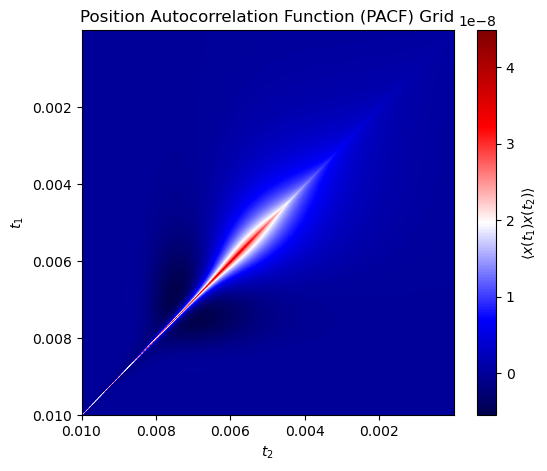

Computing I(tau):   0%|          | 0/5 [00:00<?, ?it/s]

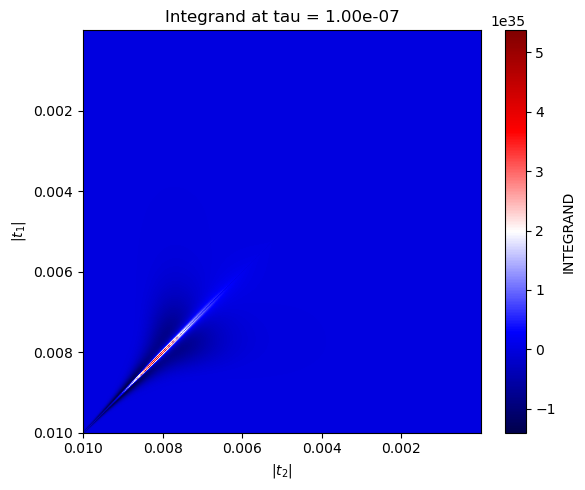

Computing I(tau):  20%|██        | 1/5 [00:42<02:49, 42.43s/it]

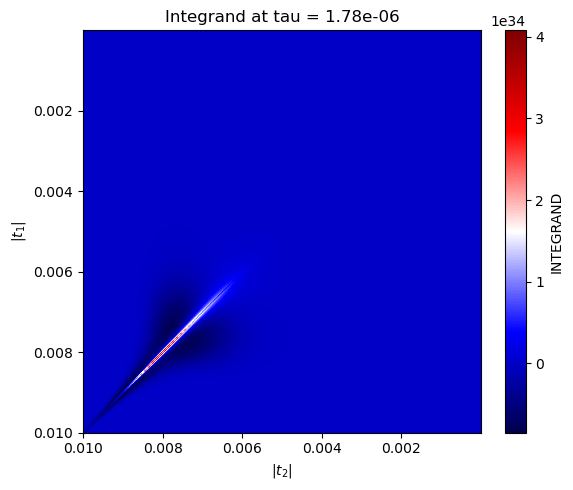

Computing I(tau):  40%|████      | 2/5 [01:23<02:04, 41.61s/it]

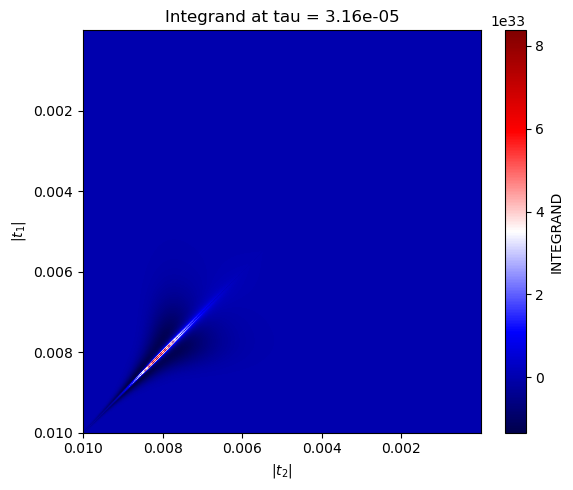

Computing I(tau):  60%|██████    | 3/5 [02:06<01:24, 42.24s/it]

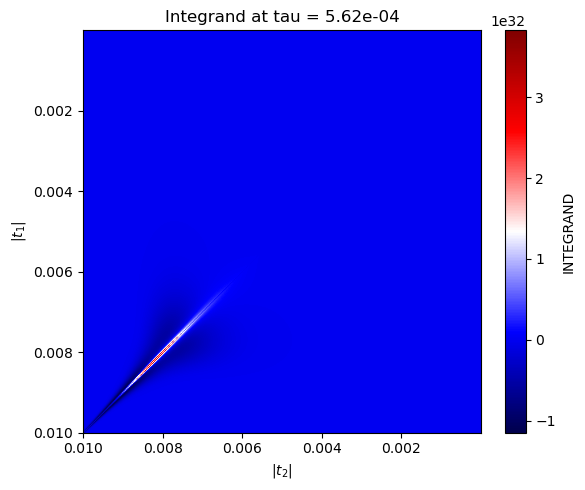

Computing I(tau):  80%|████████  | 4/5 [02:49<00:42, 42.51s/it]

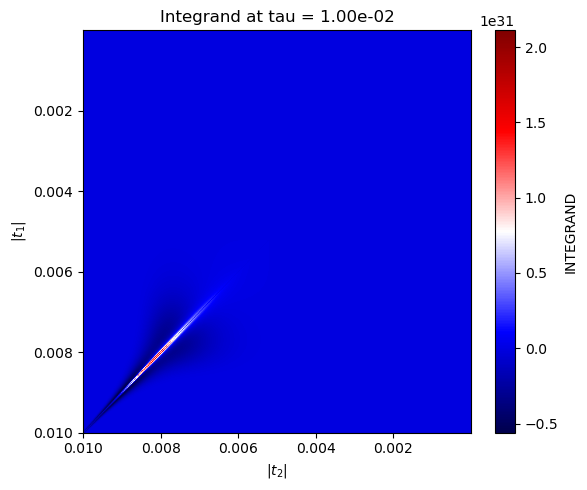

Computing I(tau): 100%|██████████| 5/5 [03:20<00:00, 40.10s/it]


In [19]:
# Let's look at the sencond moment of the history term

# we are going to evaluate the double integral of the VACF times the inverse laplace x2 of the laplace transform of 1/2(t-tau)^1.5 over the denom

# t1 and t2 are what we integrate over
# tau is the constant in the inverse laplace

import numpy as np
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpf
from tqdm import tqdm

roots = [108.66994871+196.31569885j, 108.66994871-196.31569885j,
             -9.77032846 +66.56826441j,  -9.77032846 -66.56826441j]

mp.dps = 30  # high-precision setting for inverse Laplace

# Laplace-domain function that we need to invert??
def F(s, tau):
    s = mp.mpc(s)
    tau = mp.mpf(tau)
    
    D = _m*(roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))

    inv =  2/mp.sqrt(-tau) - 2 * (mp.exp(-tau*s) * mp.sqrt(s) * mp.sqrt(mp.pi) * mp.erfc(mp.sqrt(-tau*s)))
    return inv / D 

def evaluate_ilt(F_func, tau, t_array):
    def F_fixed_tau(s):
        #Fix tau and return F(s, tau) as a function of s only
        return F_func(s, tau)

    results = []
    for t in t_array:
        t_val = abs(mpf(t))  # use |t| as required by invertlaplace
        ilt_val = invertlaplace(F_fixed_tau, s='s', t=t_val, method='talbot')
        results.append(float(ilt_val))

    return np.array(results)

Tmax = 1e-2
Tmin = 1e-9
N = 500

t_array = -np.logspace(np.log10(Tmin), np.log10(Tmax), N)[::-1]

# --- Create static vACF grid ---
T1, T2 = np.meshgrid(t_array, t_array, indexing='ij')
VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K)

tau_vals = np.logspace(-7, -2, 5)
I_tau = []


plt.figure(figsize=(6, 5))
# plt.imshow(PACF_grid, extent=[-t_array[-1], -t_array[0], -t_array[-1], -t_array[0]],
#            origin='lower', aspect='auto', cmap='seismic')
plt.imshow(VACF_grid, extent=[-t_array[0], -t_array[-1], -t_array[0], -t_array[-1]],
            origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label=r'$\langle x(t_1)x(t_2) \rangle$')
plt.xlabel(r'$t_2$')
plt.ylabel(r'$t_1$')
plt.title('Position Autocorrelation Function (PACF) Grid')
plt.grid(False)
plt.show()

for tau in tqdm(tau_vals, desc="Computing I(tau)"):
    ILT_vals = evaluate_ilt(F, tau, t_array)
    ILT1 = ILT_vals[:, np.newaxis]
    ILT2 = ILT_vals[np.newaxis, :]
    
    integrand = VACF_grid * ILT1 * ILT2
    np.fill_diagonal(integrand, 0.0)
    
    # Flip time axis to positive (absolute time)
    t_abs = -t_array  # shape (N,)
    
    plt.figure(figsize=(6, 5))
    plt.imshow(integrand, extent=[-t_array[0], -t_array[-1], -t_array[0], -t_array[-1]],
            origin='lower', aspect='auto', cmap='seismic')
    plt.colorbar(label=r'INTEGRAND')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel(r'$|t_2|$')
    plt.ylabel(r'$|t_1|$')
    plt.title(f'Integrand at tau = {tau:.2e}')
    plt.tight_layout()
    plt.show()
    
    integral = trapz(trapz(integrand, t_array, axis=1), t_array)
    I_tau.append(integral)

I_tau = np.array(I_tau)

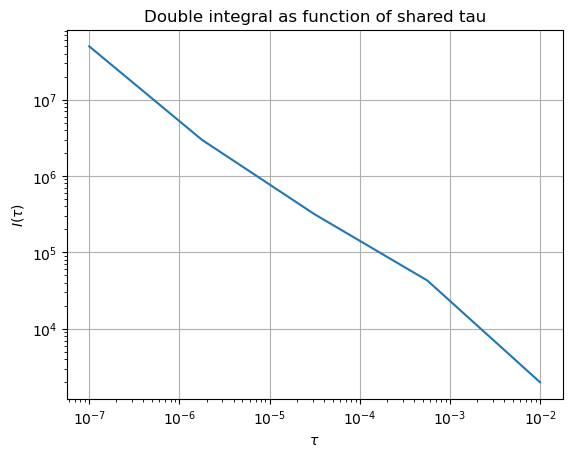

ValueError: operands could not be broadcast together with shapes (5,) (1000,) 

In [21]:

# --- Result: tau_vals (x-axis), I_tau (y-axis) ---
import matplotlib.pyplot as plt
z = 3*_r**2*np.sqrt(np.pi*_viscous*_rho_f)
plt.plot(tau_vals, np.abs(I_tau*z**2))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$I(\tau)$')
plt.title('Double integral as function of shared tau')
plt.grid(True)
plt.show()

# interpolate times_analytic, speeds_analytic_no_half[i]
plt.plot(times_analytic, (I_tau*z**2)/speeds_analytic_no_half[0], label = "Hist Second Moment ratio")
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
# plt.xlim(left=1e-6)
# plt.ylim(bottom=-1, top=1)
plt.show()


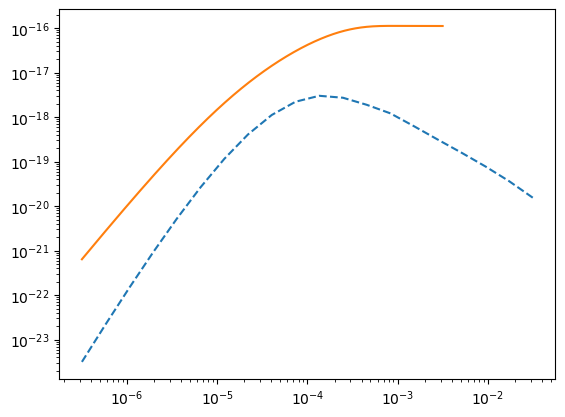

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc

# High precision for inverse Laplace
mp.dps = 30

roots = [108.66994871+196.31569885j, 108.66994871-196.31569885j,
         -9.77032846 +66.56826441j,  -9.77032846 -66.56826441j]

# History term in Laplace domain - see overlead doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 2/sqrt(-tau) - 2 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))
    
# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1
N = 100
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
z = 3*_r**2*np.sqrt(np.pi*_viscous*_rho_f)

# Fixed t value at which to evaluate MSD_history(t) importance
t_evals = np.logspace(-6.5, -1.5, 20)
msd_hs = []

for t_eval in t_evals:
    # Compute f(t, tau) for all tau
    f_vals = np.array([f(t_eval, tau) for tau in tau_array]) # tau is backwards time, t_eval is forwards

    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = f_vals[:, np.newaxis]
    f2 = f_vals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aprroximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...

    # Integrate over tau1 and tau2
    msd_history = trapz(trapz(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)

plt.plot(t_evals, msd_hs, linestyle='dashed', label="g")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = "msd")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.show()

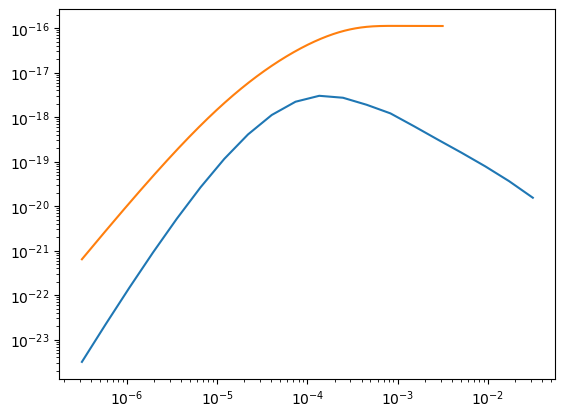

In [32]:
plt.plot(t_evals, msd_hs)
plt.plot(times_analytic, speeds_analytic_no_half[0], label = "msd")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.show()